In [10]:
import os
import numpy as np
from datetime import datetime
import learning_lidar.utils.global_settings as gs
import learning_lidar.utils.vis_utils as vis_utils
import pandas as pd
#import learning_lidar.preprocessing.preprocessing as prep
#import learning_lidar.preprocessing.preprocessing_utils as prep_utils
#from learning_lidar.generation.daily_signals_generations_utils import  calc_poiss_measurement,calc_range_corr_measurement
#import learning_lidar.generation.generation_utils as gen_utils
#import learning_lidar.dataseting.dataseting as dataseting
import learning_lidar.utils.xr_utils as xr_utils
import xarray as xr
vis_utils.set_visualization_settings()
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from pytictoc import TicToc
from learning_lidar.utils import misc_lidar
from typing import Union

# 1. Set station parameters

In [3]:
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()

main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.path.curdir))), 'data')
data_folder

'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\data'

# 2. Loading csv of the dataset

In [4]:
start_date = datetime(2017, 4, 1)
end_date = datetime(2017, 10, 31)
gen_base_name = f"dataset_gen_{station_name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}"

csv_gen_train_path = os.path.join(data_folder,f"{gen_base_name}_train.csv")
csv_gen_test_path = os.path.join(data_folder,f"{gen_base_name}_test.csv")
print(csv_gen_train_path)
print(csv_gen_test_path)

df_gen_train = pd.read_csv(csv_gen_train_path)
df_gen_test = pd.read_csv(csv_gen_test_path)

C:\Users\addalin\Dropbox\Lidar\lidar_learning\data\dataset_gen_haifa_2017-04-01_2017-10-31_train.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\data\dataset_gen_haifa_2017-04-01_2017-10-31_test.csv


# 3. Set Poisson and range corrected functions

In [11]:

def apply_poisson_xr(da_mean: Union[xr.DataArray, xr.Dataset], poiss_step_th:int = 50)-> Union[xr.DataArray, xr.Dataset]:
    """
    Calculated the Poisson signal of a data array such that: poiss_da ~ Poiss(da_mean).
    :param da_mean: xr object containing mean values of the Poiss signal.
    :param poiss_step_th: Threshold to apply the poisson STEP algorithm for lower values.
    This ensures non-negative values in poiss_da. All other values are calculated using the estimation of Normal distribution (which is faster).
    :return: poiss_da: the calculated Poiss signal.
    """
    tic0 = TicToc()
    tic0.tic()
    da_high = xr.apply_ufunc(
        lambda mu: (mu + (np.sqrt(mu)) * np.random.normal(loc=0, scale=1.0, size=mu.shape)).astype(int),
        da_mean.where(da_mean >= poiss_step_th).fillna(0), keep_attrs=True)

    da_low = xr.apply_ufunc(lambda mu: misc_lidar.generate_poisson_signal_STEP(mu),
                          da_mean.where(da_mean < poiss_step_th).fillna(0), keep_attrs=True, dask='parallelized')
    tic0.toc()
    poiss_da = da_high + da_low
    return poiss_da

def calc_range_corr_xr(station:gs.Station, in_signal : Union[xr.DataArray, xr.Dataset]) -> Union[xr.DataArray, xr.Dataset]:
    """
    Calculate the rage corrected signal of in_signal
    :param station: gs.station() object of the lidar station
    :param in_signal: xr object containing the signal to be range corrected
    :return: range_corr_signal: The range corrected signal
    """

    start_bin = 0
    end_bin = in_signal.Height.size
    height_bins = station.get_height_bins_values()[start_bin:end_bin]
    r_im = np.tile(height_bins.reshape(height_bins.size, 1), p_bg_da.Time.size)
    rr_im = r_im ** 2
    range_corr_signal = xr.apply_ufunc(lambda x,r2: x*r2,
                          in_signal,rr_im, keep_attrs=True, dask='parallelized')
    return range_corr_signal

# Testing the effect of noise on p_bg in the NN
Add Poisson to background of split samples. This is applied to test and train datasets
## 1. Load background data prior to Poisson

E:\data_haifa\GENERATION\bg_dataset\2017\09\2017_09_02_133000_135930_Haifa_generated_p_bg_355_bg.nc


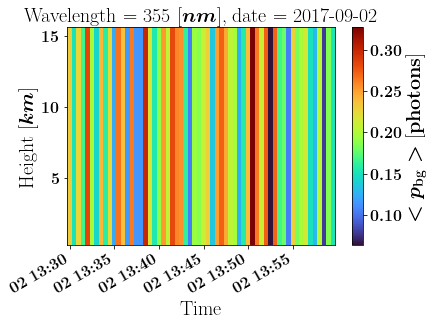

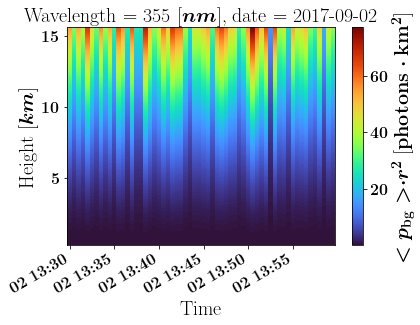

In [12]:
n_sample = 62
nc_path = os.path.join(station.nn_source_data, df_gen_train.bg_path.iloc[n_sample])
print(nc_path)

# Load NC of sample dataset
bg_ds = xr_utils.load_dataset(ncpath=nc_path)

# Show bg and range corrected bg (without Poisson)
bg_ds.p_bg.plot(cmap='turbo')
plt.show()
bg_ds.p_bg_r2.plot(cmap='turbo')
plt.show()



## 2. Apply Poisson on p_bg and calc the range corrected signal (using xr framework)

poisson STEP: 100%|██████████| 122880/122880 [00:01<00:00, 109051.99it/s]


Elapsed time is 1.139278 seconds.


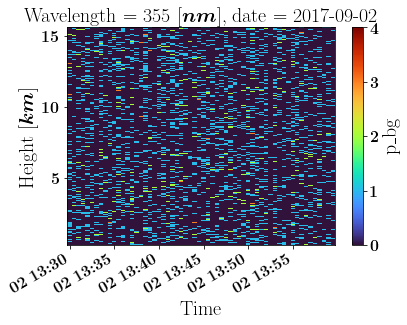

Elapsed time is 0.001808 seconds.


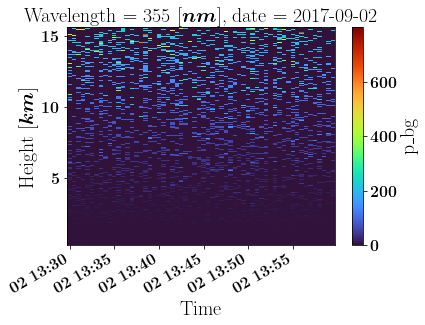

In [14]:
p_bg_da = apply_poisson_xr(bg_ds.p_bg)
p_bg_da.plot(cmap='turbo')
plt.show()
tic1 = TicToc()
tic1.tic()
range_corr = calc_range_corr_xr(station,p_bg_da)
tic1.toc()
range_corr.plot(cmap='turbo')
plt.show()

## 3. Test differences between xr and pytorch values and plots

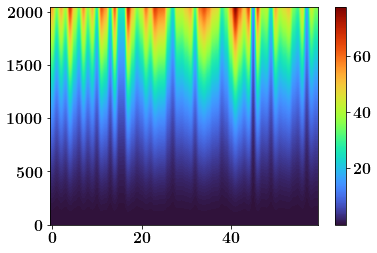

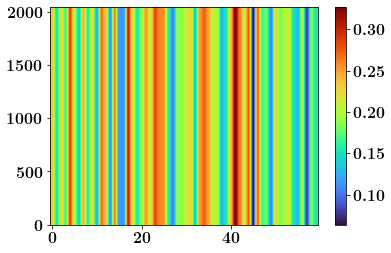

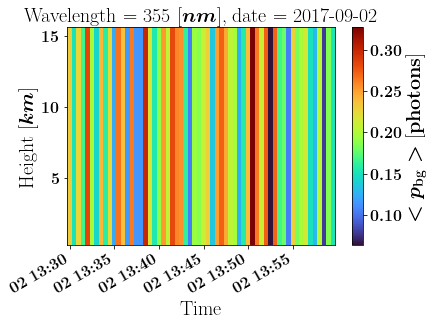

In [15]:
p_bgr2_torch = torch.from_numpy(bg_ds.p_bg_r2.values)
plt.imshow(  p_bgr2_torch, aspect='auto', cmap='turbo')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

p_bg_torch = torch.from_numpy(bg_ds.p_bg.values)
plt.imshow(p_bg_torch, aspect='auto', cmap='turbo')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()
bg_ds.p_bg.plot(cmap='turbo')
plt.show()

## 4. Apply Poisson using pytorch framework and compare to xr implementation

Elapsed time is 0.003312 seconds.


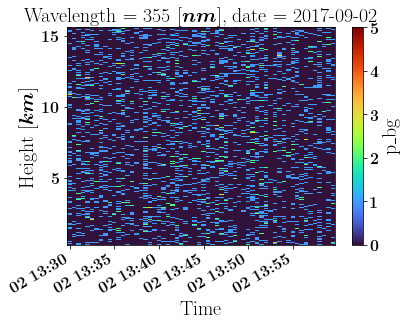

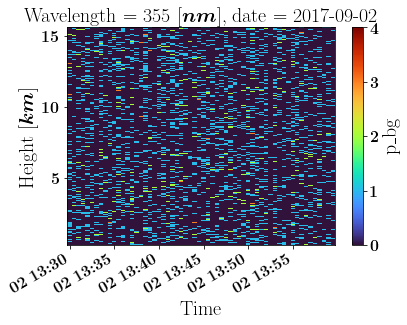

In [27]:
t2 = TicToc()
t2.tic()
p_bg_torch_poiss = torch.poisson(p_bg_torch)
t2.toc()
#plt.imshow(p_bg_torch_poiss, aspect='auto', cmap='turbo')
#plt.gca().invert_yaxis()
#plt.colorbar()
#plt.show()


tmp_bg = p_bg_da.copy(deep=True)
tmp_bg.values = p_bg_torch_poiss.numpy()
tmp_bg.plot(cmap='turbo')
plt.show()
p_bg_da.plot(cmap = 'turbo')
plt.show()

## 5. Calculate range corrected signal using pytorch , and compare to the implementation of xr

Elapsed time is 0.001507 seconds.


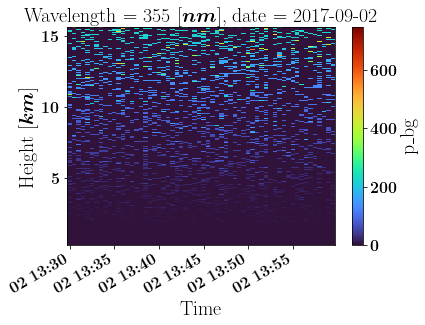

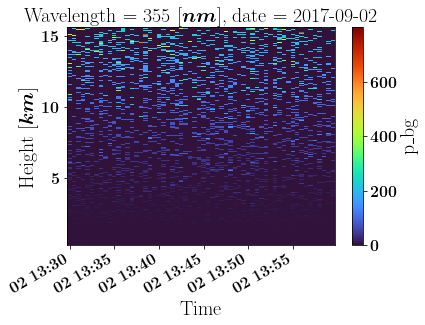

In [41]:
start_bin = 0
end_bin = bg_ds.Height.size
total_time_bins = p_bg_da.Time.size
height_bins = station.get_height_bins_values()[start_bin:end_bin]
t3 = TicToc()
t3.tic()
r_im = np.tile(height_bins.reshape(height_bins.size, 1), total_time_bins)
rr_im = r_im ** 2
p_bg_torch_poiss_r2 = p_bg_torch_poiss * torch.from_numpy(rr_im)
t3.toc()

tmp_bg_r2 = p_bg_da.copy(deep=True)
tmp_bg_r2.values = p_bg_torch_poiss_r2.numpy()
tmp_bg_r2.plot(cmap='turbo')
plt.show()
range_corr.plot(cmap = 'turbo')
plt.show()


In [70]:
height_bins_t = torch.from_numpy(height_bins)
tic4 = TicToc()
tic4.tic()
range_corr_t = torch.matmul(torch.diag(height_bins_t),p_bg_torch_poiss.double())
tic4.toc()



r_im_t = height_bins_t.tile(total_time_bins,1).T
rr_im_t = r_im_t ** 2
t5 = TicToc()
t3.tic()
p_bg_torch_poiss_r2 = p_bg_torch_poiss * rr_im_t
t3.toc()

Elapsed time is 0.015721 seconds.
Elapsed time is 0.000612 seconds.


In [65]:
r_im_t = height_bins_t.tile(total_time_bins,1).T

In [ ]:
from torchvision import  transforms

transforms.Lambda(lambda x: x.convert('RGB'))